# Advanced Tutorial 7: Learning Rate Scheduling

## Overview

In this tutorial, we will discuss:

* [Customizing a Learning Rate Schedule Function](#ta07customize)
    * [epoch-wise](#ta07epoch)
    * [step-wise](#ta07step)
* [Using a Built-In lr_schedule Function](#ta07builtin)
    * [cosine decay](#ta07cosine)
* [Related Apphub Examples](#ta07apphub)

Learning rate schedules can be implemented using the `LRScheduler` `Trace`. `LRScheduler` takes the model and learning schedule through the **lr_fn** parameter. **lr_fn** should be a function/lambda function with 'step' or 'epoch' as its input parameter. This determines whether the learning schedule will be applied at a step or epoch level.

For more details on traces, you can visit [tutorial 7](../beginner/t07_estimator.ipynb) in the beginner section and [tutorial 4](./t04_trace.ipynb) in the advanced section. 

Let's create a function to generate the pipeline, model, and network to be used for this tutorial:

In [1]:
import fastestimator as fe
from fastestimator.architecture.tensorflow import LeNet
from fastestimator.dataset.data import mnist
from fastestimator.op.numpyop.univariate import ExpandDims, Minmax
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp


def get_pipeline_model_network(model_name="LeNet"):
    train_data, _ = mnist.load_data()

    pipeline = fe.Pipeline(train_data=train_data,
                           batch_size=32,
                           ops=[ExpandDims(inputs="x", outputs="x"), 
                                Minmax(inputs="x", outputs="x")])

    model = fe.build(model_fn=LeNet, optimizer_fn="adam", model_name=model_name)

    network = fe.Network(ops=[
        ModelOp(model=model, inputs="x", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
        UpdateOp(model=model, loss_name="ce")
    ])

    return pipeline, model, network

<a id='ta07customize'></a>

## Customizing a Learning Rate Schedule Function
We can specify a custom learning schedule by passing a custom function to the **lr_fn** parameter of `LRScheduler`. We can have this learning rate schedule applied at either the epoch or step level. Epoch and step both start from 1.

<a id='ta07epoch'></a>

### Epoch-wise
To apply learning rate scheduling at an epoch level, the custom function should have 'epoch' as its parameter. Let's look at the example below which demonstrates this. We will be using the summary parameter in the fit method to be able to visualize the learning rate later. You can go through [tutorial 6](./t06_summary.ipynb) in the advanced section for more details on accessing training history.

In [2]:
from fastestimator.summary.logs import visualize_logs
from fastestimator.trace.adapt import LRScheduler

def lr_schedule(epoch):
    lr = 0.001*(20-epoch+1)/20
    return lr

pipeline, model, network = get_pipeline_model_network()

traces = LRScheduler(model=model, lr_fn=lr_schedule)
estimator = fe.Estimator(pipeline=pipeline, network=network, epochs=3, traces=traces)

history = estimator.fit(summary="Experiment_1")

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-Start: step: 1; num_device: 0; logging_interval: 100; 
FastEstimator-Train: step: 1; ce: 2.3121834; LeNet_lr: 0.001; 
FastEstimator-Train: step: 100; ce: 0.3843257; steps/sec: 139.02; LeNet_lr: 0.001; 
FastEstimator-Train: step: 200; ce: 0.117751315; steps/sec: 131.96; LeNet_lr: 0.001; 
FastEstimator-Train: step: 300; ce: 0.20433763; steps/sec: 129.58; LeNet_lr: 0.001; 
FastEstimator-Train: step: 400; ce: 0.10046323; steps/sec: 122.35; LeNet_lr: 0.001; 
FastEstimator

The learning rate is available in the training log at steps specified using the log_steps parameter in the `Estimator`. By default, training is logged every 100 steps.

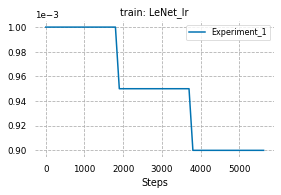

In [3]:
visualize_logs(history, include_metrics="LeNet_lr")

As you can see, the learning rate changes only after every epoch.

<a id='ta07step'></a>

### Step-wise
The custom function should have 'step' as its parameter for step-based learning rate schedules. 

In [4]:
def lr_schedule(step):
    lr = 0.001*(7500-step+1)/7500
    return lr

pipeline, model, network = get_pipeline_model_network()

traces = LRScheduler(model=model, lr_fn=lr_schedule)
estimator = fe.Estimator(pipeline=pipeline, network=network, epochs=2, traces=traces)

history2 = estimator.fit(summary="Experiment_2")

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-Start: step: 1; num_device: 0; logging_interval: 100; 
FastEstimator-Train: step: 1; ce: 2.3268642; LeNet_lr: 0.001; 
FastEstimator-Train: step: 100; ce: 0.34729302; steps/sec: 81.02; LeNet_lr: 0.0009868; 
FastEstimator-Train: step: 200; ce: 0.16947752; steps/sec: 79.79; LeNet_lr: 0.00097346667; 
FastEstimator-Train: step: 300; ce: 0.1158019; steps/sec: 79.11; LeNet_lr: 0.00096013333; 
FastEstimator-Train: step: 400; ce: 0.08662731; steps/sec: 77.06; LeNet_lr: 0.0009

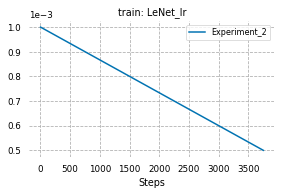

In [5]:
visualize_logs(history2, include_metrics="LeNet_lr")

<a id='ta07builtin'></a>

## Using Built-In lr_schedule Function
Some learning rates schedules are widely popular in the deep learning community. We have implemented some of them in FastEstimator so that you don't need to write a custom schedule for them. We will be showcasing the `cosine decay` schedule below.

<a id='ta07cosine'></a>

### cosine_decay
We can specify the length of the decay cycle and initial learning rate using cycle_length and init_lr respectively. Similar to custom learning schedule, lr_fn should have step or epoch as a parameter. The FastEstimator cosine decay can be used as follows:

In [6]:
from fastestimator.schedule import cosine_decay

pipeline, model, network = get_pipeline_model_network()

traces = LRScheduler(model=model, lr_fn=lambda step: cosine_decay(step, cycle_length=1875, init_lr=1e-3))
estimator = fe.Estimator(pipeline=pipeline, network=network, epochs=2, traces=traces)

history3 = estimator.fit(summary="Experiment_3")

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-Start: step: 1; num_device: 0; logging_interval: 100; 
FastEstimator-Train: step: 1; ce: 2.3090043; LeNet_lr: 0.001; 
FastEstimator-Train: step: 100; ce: 0.34759182; steps/sec: 72.64; LeNet_lr: 0.0009931439; 
FastEstimator-Train: step: 200; ce: 0.124293044; steps/sec: 72.99; LeNet_lr: 0.0009724906; 
FastEstimator-Train: step: 300; ce: 0.11162343; steps/sec: 76.42; LeNet_lr: 0.00093861774; 
FastEstimator-Train: step: 400; ce: 0.1846501; steps/sec: 73.36; LeNet_lr: 0.0

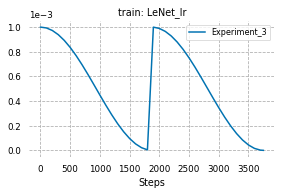

In [7]:
visualize_logs(history3, include_metrics="LeNet_lr")

<a id='ta07apphub'></a>

## Apphub Examples
You can find some practical examples of the concepts described here in the following FastEstimator Apphubs:

* [MNIST](../../apphub/image_classification/mnist/mnist.ipynb)
* [CIFAR10](../../apphub/image_classification/cifar10_fast/cifar10_fast.ipynb)